In [1]:
%load_ext autoreload
%autoreload 2

# fundamentals
import os, sys
import numpy as np
import pandas as pd
from calendar import monthrange, month_name
import scipy.stats as stats
import datetime
import imp
import scipy.io as sio
import pickle as pkl

# plotting libraries and setup
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
plt.style.use('nrelplot')
from windrose import WindroseAxes

# met mast functions and utilities
sys.path.append('../')
import met_funcs as MET
import vis as vis
import utils as utils

In [2]:
datapath = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/IEC_4/'
monthly_events_files = os.listdir(datapath)
today = datetime.date.today()
figpath = '../figs_{}{}{}'.format(str(today.year), str(today.month).zfill(2), str(today.day).zfill(2))

try:
    os.makedirs(figpath)
except:
    pass

In [8]:
###########################################
def rose_fig(metdat, varcol, dircol, bins=6, nsector=36, ylim=None, noleg=False):
    ###########################################
    """
    make wind rose from pandas.Series wind direction and some other value of the same size.
    Parameters:
        metdat:
            Pandas dataframe containing met mast data
        catinfo:
            dict containing categorization info for the metmast data. Fore each category,
            catinfo holds column names, labels, units, and save names
        category:
            string specifying category of information to plot (e.g. 'speed', 'stability', etc.)
        vertloc:
            int or float describing the exact or approximate height of interest along the tower
        bins:
            int specifying number of equally spaced bins to divide var.
            OR
            list of bin division limits (eg [0,4,8,12,16])
        nsector:
            number or direction sectors to divide rose
        ylim:
            optional float with maximum value for frequency of observations, use to
            plot different roses with uniform limits
        noleg:
            bool switch to turn legend off
    """

    # set up data
    winddir = metdat[dircol]
    var = metdat[varcol]

    relabel = False
    if not isinstance(bins, int):
        if ((bins < 0).any()):
            bins *= -1
            relabel = True
        
    # get var divisions set up
    if isinstance(bins, int):
        nbins = bins
    else:
        nbins = len(bins)

    # set up plotting colors
    colors = utils.get_colors(nbins-1, basecolor='span')
    colors += ['#3A4246'] # add something dark to the end.
    colors = tuple(colors[0:nbins])

    # built figure
    fig = plt.figure()
    ax = WindroseAxes.from_ax(fig=fig)
    ax.bar(winddir, var, normed=True, opening=0.95, edgecolor='white', bins=bins, nsector=nsector, colors=colors, linewidth=0.35)

    # legend
    leg=['blank']
    if noleg is not True:
        leg = ax.set_legend(loc=6,bbox_to_anchor=(1.25,0.5), fontsize=10, frameon=False)
        
        if relabel:
            for ii in range(nbins-1):
                leg.get_texts()[ii].set_text('[{}: {})'.format(-bins[ii], -bins[ii+1]))
            leg.get_texts()[-1].set_text('[{}: {})'.format(-bins[-1], '-inf'))

    # adjust plot for specified max frequency
    if ylim is None:
        ylim = ax.get_ylim()[-1]

    # frequency axis limits and labels
    ax.set_ylim(0,ylim)
    ax.set_yticks(np.linspace(0,ylim,4))
    ax.set_yticklabels([str(round(x,1)) for x in np.linspace(0,ylim,4)])


    return fig, ax, leg
###########################################

def extreme_event_hist(eventdf, varcols, labels, bins=25, colors=None, alpha=1):
    '''
    
    '''
    
    fig, ax = plt.subplots(figsize=(5,3))

    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]

    for ii, var in enumerate(varcols):
        data = eventdf[var].dropna(how='any')


        n,histbins,patches = ax.hist(data,
                                    bins = bins,
                                    facecolor=colors[ii],
                                    edgecolor='k',
                                    weights=100*np.ones(data.shape) / len(data), 
                                    density=False,
                                    label=labels[ii], alpha=alpha)
    leg = ax.legend(frameon=False)
    ax.set_ylabel('Frequency [\%]')
    
    return fig, ax, leg

def extreme_event_wind_direction_bar(eventdf, varcols, labels, colors=None):
    '''
    
    '''
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]
        
    event_bydir = eventdf.groupby('dirbin').count()
    tmp = event_bydir[varcols].copy()
    tmp = 100*tmp.div(tmp.sum())

    fig, ax = plt.subplots(figsize=(8,3))
    
    tmp.plot.bar(ax=ax, color=colors[:len(varcols)], width=0.9, edgecolor='k')
    leg  = ax.legend(labels)
    ax.set_xticks(ax.get_xticks()[::2])
    ax.set_xlabel('Wind Direction [$^\circ$]')
    ax.set_ylabel('Frequency [\%]')

    return fig, ax, leg

# fig.savefig('../figs_20190109/alpha_bar.pdf')

def extreme_event_monthly_bar(eventdf, varcols, labels, colors=None):
    '''
    
    '''
    
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]

    numyears = eventDF.index.year.max() - eventDF.index.year.min()
    monthly = eventdf[varcols].groupby(eventdf.index.month).count()/numyears
#     monthly = monthly.div(monthly.sum())*100

    fig, ax = plt.subplots(figsize=(5,3))
    monthly.plot.bar(ax=ax, label=labels, color=colors[:len(varcols)])
    ax.set_xlabel('Month')
    ax.set_ylabel('Events Per Month')
    leg = ax.legend(labels, frameon=False)

    return fig, ax, leg 


def extreme_event_velocity_scatter(eventdf, varcols, labels, colors=None, ):
    '''
    
    '''
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        colors = [colors[x] for x in [2,1,3]]
    
    fig, ax = plt.subplots(figsize=(5,3))

    for ii, var in enumerate(varcols):
        eventdf.plot.scatter('WS_mean', var, ax=ax, edgecolor=colors[ii], color='w', label=labels[ii])

    ax.set_xlabel('Hub-Height Velocity [m/s]')
    ax.legend(frameon=False)

    return fig, ax, leg 

In [242]:
# time range
# years  = [ int(a) for a in np.arange(2012,2019,1) ] #
# months = [ int(a) for a in np.arange(1,12.1,1) ]
# days = [int(a) for a in np.arange(1,31.1,1)]

years  = [ 2015 ] #
months = [ 11 ]
days = [int(a) for a in np.arange(1,8.1,1)]

# paths (must mount volume smb://nrel.gov/shared/wind/WindWeb/MetData/135mData/)
towerID = 'M5'
metDataPath = '/Volumes/135mData/{}Twr/20Hz/mat/'.format(towerID)

savepath = '/Users/nhamilto/Documents/Wake_Dynamics/SiteChar/data/IEC_3'
try:
    os.makedirs(savepath)
except:
    pass

In [243]:
wskeys = [x for x in data.keys() if 'Speed' in x or 'WS' in x]
wdkeys = [x for x in data.keys() if 'direction' in x or 'WD' in x]
probeheight = str(87)
datakeys = [['time_UTC'], [x for x in wskeys if probeheight in x], [x for x in wdkeys if probeheight in x]]
datakeys = [item for sublist in datakeys for item in sublist]

for year in years:
    for month in months:

        # begin empty lists for events
        EDCevents = pd.DataFrame()
        ECDevents = pd.DataFrame()
        
        print('reading 20Hz data for {}/{}'.format(year, month))

        for day in days:
            sonicdat = pd.DataFrame()
            
            datapath = os.path.join(metDataPath, str(year),
                                    str(month).zfill(2),
                                    str(day).zfill(2))

            # establish existence of directory
            try:
                fPaths = os.listdir(datapath)
            except:
                print('empty datapath: {}'.format(datapath))
                continue

            if len(fPaths) is 0:
                continue

            for filenum, file in enumerate(fPaths):

                # load data
                
                try:
                    data = sio.loadmat(os.path.join(datapath, file), variable_names=datakeys)
                except:
                    print('data not found? looks like you have some homework...')
                    continue

                # print('data loaded from {}'.format(os.path.join(datapath, file)))
                data = {key: data[key][0][0][0].squeeze() for key in datakeys}
                data['time_UTC'] = utils.matlab_datenum_to_python_datetime(data['time_UTC'])
                data = pd.DataFrame.from_dict(data)
                data.set_index('time_UTC', inplace=True)
                data.index = pd.DatetimeIndex(data.index)

                sonicdat = pd.concat([sonicdat, data])
                
            sonicdat.columns = ['WS', 'WD']
            sonicdat = sonicdat.rolling(60, center=True, min_periods=1).mean()
#             sonicdat.index = pd.DatetimeIndex(sonicdat.index)

            temp = sonicdat['WS'].dropna()
            if len(temp) < 1000:
                continue

            # extract variables needed for classificiation of IEC events
            params = MET.setup_IEC_params() # sonicdat, probeheight=100

            EDC_events_found = MET.find_EDC_events(sonicdat, params)
            EDCevents = pd.concat([EDCevents, EDC_events_found])

            EDC_events_found = EDC_alt(sonicdat, params)
            EDCeventsALT = pd.concat([EDCevents, EDC_events_found])
#             ECD_events_found = MET.find_ECD_events(sonicdat, params)
#             ECDevents = pd.concat([ECDevents, ECD_events_found])

#                 allshearcalcs = pd.concat([allshearcalcs, shearevents])
                                
#         if len(EWSevents) > 0:
#             filename = 'EWSevents_{}_{}.pkl'.format(year, month)
#             savefile = os.path.join(savepath, filename)
#             print('EWS event detected. Stored to: {}'.format(filename))
#             with open(savefile, 'wb') as f:
#                 pkl.dump(EWSevents, f, pkl.HIGHEST_PROTOCOL)

reading 20Hz data for 2015/11
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/01
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/02
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/03
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/04
empty datapath: /Volumes/135mData/M5Twr/20Hz/mat/2015/11/05


/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [244]:
EDCevents.shape

(989, 9)

In [245]:
EDCeventsALT.shape

(1177, 10)

In [332]:
wskeys = ['Cup_WS_C1_130m',
 'Cup_WS_122m',
 'Cup_WS_C1_105m',
 'Cup_WS_87m',
 'Cup_WS_C1_80m',
 'Cup_WS_C1_55m',
 'Cup_WS_38m',
 'Cup_WS_C1_30m',
 'Cup_WS_10m',
 'Cup_WS_3m',
 'Sonic_CupEqHorizSpeed_119m',
 'Sonic_CupEqHorizSpeed_100m',
 'Sonic_CupEqHorizSpeed_74m',
 'Sonic_CupEqHorizSpeed_61m',
 'Sonic_CupEqHorizSpeed_41m',
 'Sonic_CupEqHorizSpeed_15m']

wdkeys = ['Vane_WD_122m',
 'Vane_WD_87m',
 'Vane_WD_38m',
 'Vane_WD_10m',
 'Vane_WD_3m',
 'Sonic_direction_119m',
 'Sonic_direction_100m',
 'Sonic_direction_74m',
 'Sonic_direction_61m',
 'Sonic_direction_41m',
 'Sonic_direction_15m']

In [253]:
EDCevents['dirbin'] = pd.cut(EDCevents['WD_mean'], np.arange(0, 360.1, 10), [str(x) for x in np.arange(5, 360.1, 10)])
EDCeventsALT['dirbin'] = pd.cut(EDCeventsALT['WD_mean'], np.arange(0, 360.1, 10), [str(x) for x in np.arange(5, 360.1, 10)])

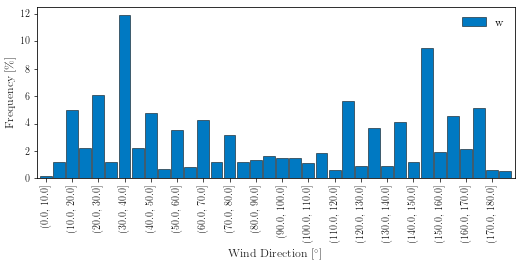

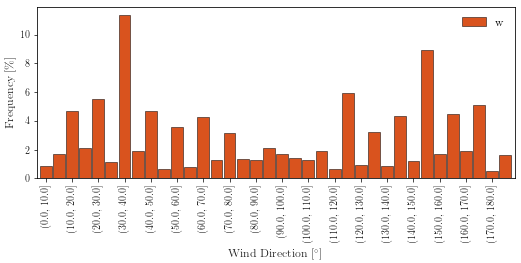

In [255]:
fig, ax, leg = extreme_event_wind_direction_bar(EDCevents, 'WD_mean', 'wdir', colors='C1')
fig, ax, leg = extreme_event_wind_direction_bar(EDCeventsALT, 'WD_mean', 'wdir', colors='C2')

In [123]:
def EDC_alt(sonicdat, params, T=6.0):
    # smoothsonic = sonicdat.rolling(60, min_periods=1).mean()
    tmp = MET.sonic_data_resampler(sonicdat, 6.0)

    # calculate diff: Delta_WD = WD_(t+1) - WD_(t-1)
    tmpa = tmp['WD_mean'].diff(periods=1)
    tmpb = tmp['WD_mean'].diff(periods=-1)
    tmp['deltaWD'] = tmpa-tmpb

    # Orient Delta_WD onto compass (i.e. change > 180 degrees corresponds to a change in the other direction)
    tmp.deltaWD[tmp.deltaWD > 180] = -360 + tmp.deltaWD[tmp.deltaWD > 180]
    tmp.deltaWD[tmp.deltaWD < -180] = 360 + tmp.deltaWD[tmp.deltaWD < -180]

    # Turbulence standard deviation depends on mean wind speed
    tmp['sigma_1'] = params['Iref'] * (0.75 * tmp['WS_mean'] + 5.6)

    # Direction change threshold depends on wind speed
    tmp['delta_WD_thresh'] = np.degrees(4 * np.arctan( tmp['sigma_1'] / (tmp['WS_mean'] * (1 + 0.1 * params['D'] / params['Lambda_1']))))

    # event detection
    tmpEDC = tmp[(tmp['deltaWD'] > tmp['delta_WD_thresh']) | (tmp['deltaWD'] < -tmp['delta_WD_thresh'])]
    
    return tmpEDC

In [116]:
# smoothsonic = sonicdat.rolling(60, min_periods=1).mean()
tmp = MET.sonic_data_resampler(sonicdat, 6.0)

# calculate diff: Delta_WD = WD_(t+1) - WD_(t-1)
tmpa = tmp['WD_mean'].diff(periods=1)
tmpb = tmp['WD_mean'].diff(periods=-1)
tmp['deltaWD'] = tmpa-tmpb

# Orient Delta_WD onto compass (i.e. change > 180 degrees corresponds to a change in the other direction)
tmp.deltaWD[tmp.deltaWD > 180] = -360 + tmp.deltaWD[tmp.deltaWD > 180]
tmp.deltaWD[tmp.deltaWD < -180] = 360 + tmp.deltaWD[tmp.deltaWD < -180]

# Turbulence standard deviation depends on mean wind speed
tmp['sigma_1'] = params['Iref'] * (0.75 * tmp['WS_mean'] + 5.6)

# Direction change threshold depends on wind speed
tmp['delta_WD_thresh'] = np.degrees(4 * np.arctan( tmp['sigma_1'] / (tmp['WS_mean'] * (1 + 0.1 * params['D'] / params['Lambda_1']))))

# event detection
tmpEDC = tmp[(tmp['deltaWD'] > tmp['delta_WD_thresh']) | (tmp['deltaWD'] < -tmp['delta_WD_thresh'])]

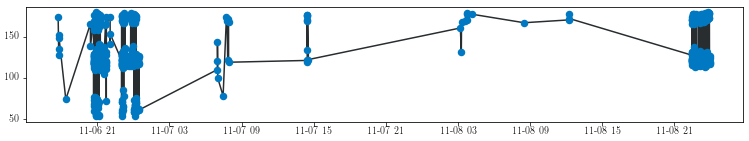

In [258]:
fig,ax = plt.subplots(figsize=(12,2))
ax.plot(EDCevents['delta_WD'])
ax.plot(EDCevents['delta_WD'], 'o')
# ax.plot(tmpEDC2['delta_WD'], 'o')

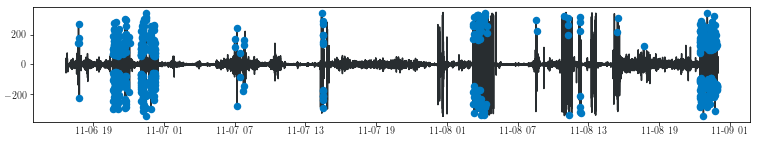

In [86]:
fig,ax = plt.subplots(figsize=(12,2))
ax.plot(tmp['deltaWD'])
ax.plot(tmpEDC['deltaWD'], 'o')

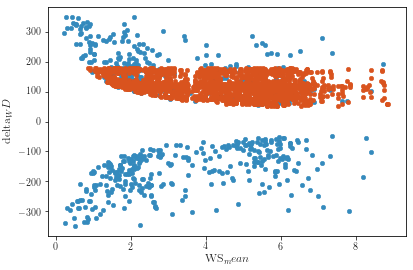

In [76]:
fig, ax = plt.subplots()
tmpEDC.plot.scatter('WS_mean', 'deltaWD', ax=ax)
EDCevents.plot.scatter('WS_mean', 'delta_WD', ax=ax, color='C2')

In [56]:
wsmean = np.linspace(0,45,100)

sigma_1 = params['Iref'] * (0.75 * wsmean + 5.6)

delta_WD_thresh = np.degrees(4 * np.arctan( sigma_1 / (wsmean * (1 + 0.1 * params['D'] / params['Lambda_1']))))

/Users/nhamilto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [47]:
MET.find_EDC_events(sonicdat, params)

,WS_min,WD_min,WS_max,WD_max,WS_mean,WD_mean,sigma_1,delta_WD_thresh,delta_WD
datetime,,,,,,,,,
2015-11-30 23:55:12,2.66198,222.166646,3.753405,311.668864,3.064868,261.038154,1.263784,76.41823,89.502218


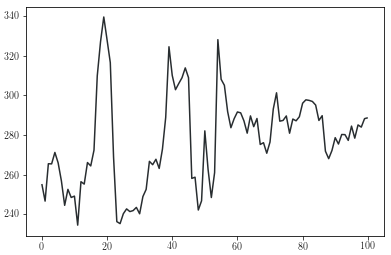

In [59]:
plt.plot(tmp['WD_mean'].values)

In [259]:
datapath

'/Volumes/135mData/M5Twr/20Hz/mat/2015/11/08'

In [260]:
datapath = os.path.join(metDataPath, str(year),
                                    str(month).zfill(2),
                                    str(day).zfill(2))

In [308]:
keys = ['time', 'WS', 'WD']
datakeys = {key:value for key,value in zip(keys,datakeys)}

In [333]:
mats = []
for file in os.listdir( datapath ) :
    mats.append( sio.loadmat( os.path.join(datapath, file) , variable_names=datakeys) )

In [311]:
# %%timeit
WS = np.array([])
WD = np.array([])
time = np.array([])

for imat in range(len(mats)):
    WS = np.append(WS, mats[imat][datakeys['WS']][0][0][0].flatten())
    WD = np.append(WD, mats[imat][datakeys['WD']][0][0][0].flatten())
    time = np.append(time, mats[imat][datakeys['time']][0][0][0].flatten())

metdat = pd.DataFrame(index=pd.DatetimeIndex(utils.matlab_datenum_to_python_datetime(time)), data=np.vstack((WS, WD)).T, columns=['WS', 'WD'])

metdat.replace(to_replace=0.0, value=np.NaN, inplace=True)
metdat.dropna(how='any', inplace=True)

6.5 s ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [313]:
metdat = metdat.rolling(60, min_periods=1).mean()
